# Лабораторная работа №1

### Цель работы
Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

### Задачи лабораторной работы

1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования.
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

## Загрузка сигнала и построение огибающей кривой

Имеется сигнал $x(i), i = 0,1,...,N-1$. Хотим построить огибающую $y(j), j = 0,1,...,n-1$. Пусть $m = \left[ \frac{N} n \right] $ - число точек в интервале усреднения. Тогда $y(i) = \frac{1} m \displaystyle\sum^{mj+m-1}_{k=mj} |x(k)| $.
Также, была реализована огибающая, которая идёт "поверх" графика сигнала с помощью выбора максимальной точки на интервале усреднения.

C:\Users\79215\AppData\Local\Temp/ipykernel_10008/4201103351.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read("03-01-05-01-01-02-14_A14.wav")


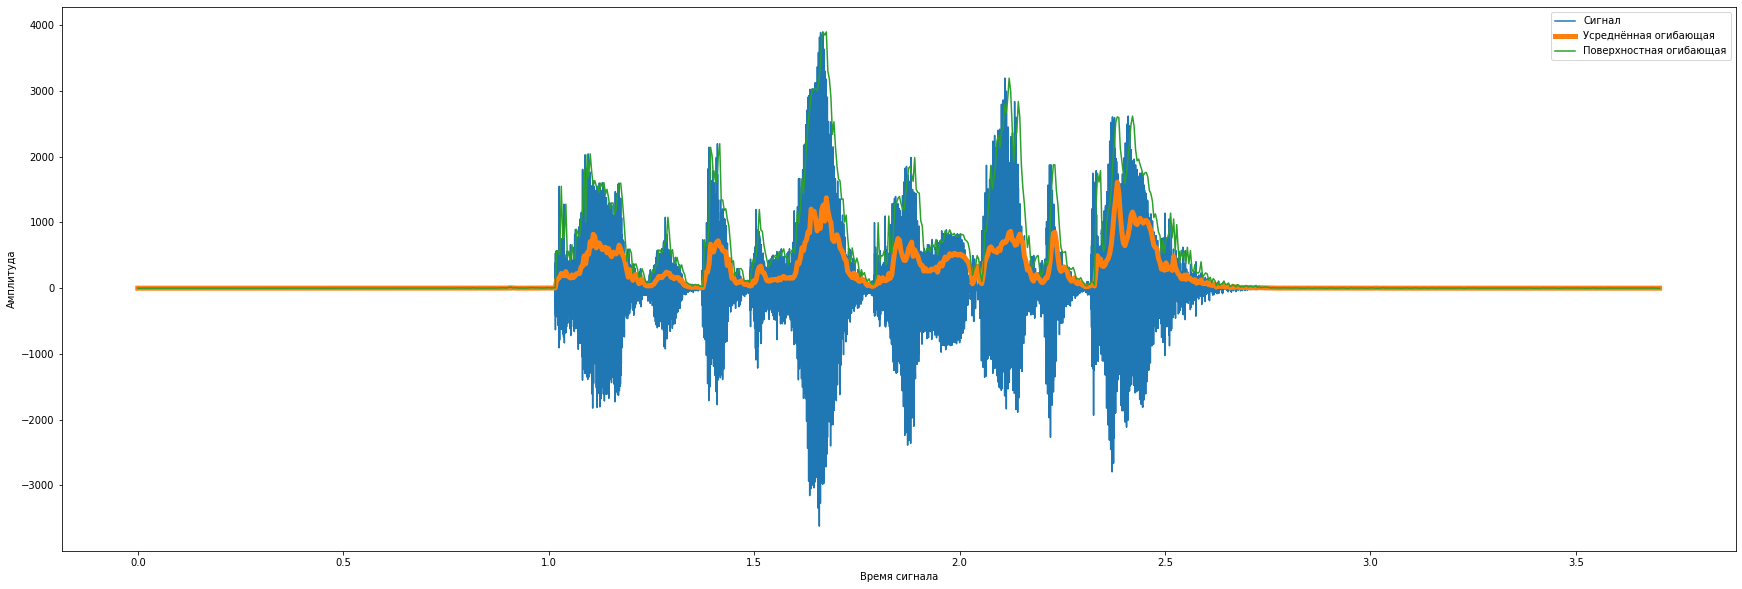

In [43]:
from scipy.io import wavfile
import scipy.io

samplerate, data = wavfile.read("03-01-05-01-01-02-14_A14.wav")

import matplotlib.pyplot as plt
import numpy as np

n = 1000
slength = data.shape[0] / samplerate
stime = np.linspace(0, slength, data.shape[0])
m = int(data.shape[0] / n)
graph = np.linspace(0, slength, n)
graph_dots = []
graph_dots1 = []
for j in range(n):
    max = data[m * j]
    sum = 0
    for k in range(m * j, m * j + m):
        sum += abs(data[k])
        if (data[k] > 0 and data[k] > max):
            max = data[k]
    graph_dots1.append(max)
    graph_dots.append(sum/m)

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.plot(stime, data, label="Сигнал")
plt.plot(graph, graph_dots, label="Усреднённая огибающая", linewidth=5)
plt.plot(graph, graph_dots1, label="Поверхностная огибающая")
plt.legend()
plt.xlabel("Время сигнала")
plt.ylabel("Амплитуда")
plt.show()

## Фильтрация сигнала

Полосовой фильтр.
Пусть $F_d$ - частота дискретизации. Необходимо отфильтровать частотные компоненты ниже 100 Гц и выше 200 Гц, то есть частота среза $F_{s1}$ = 100 Гц и $F_{s2}$ = 200 Гц. Тогда $wn_1 = 2\frac{F_{s1}} {F_{d}}$ и $wn_2 = 2\frac{F_{s2}} {F_{d}}$, $wn = [wn_1, wn_2]$

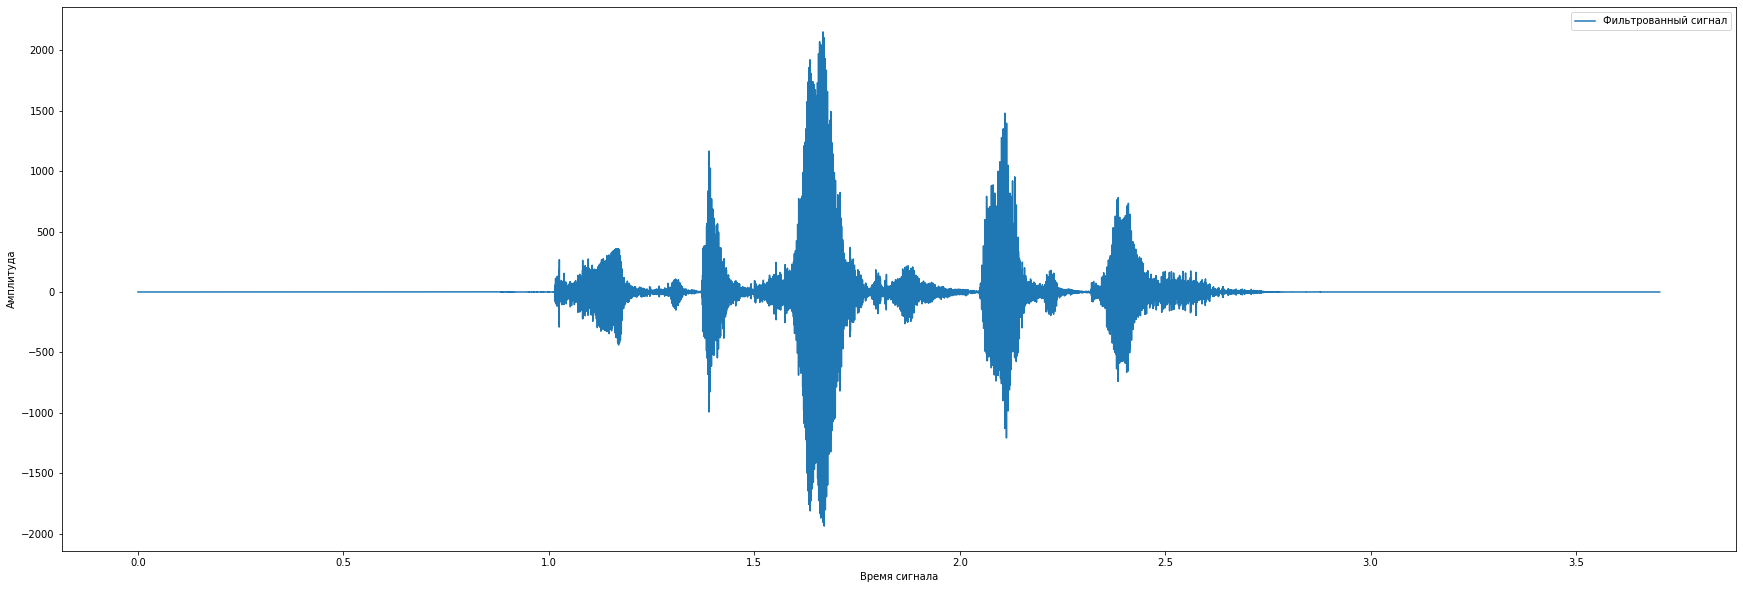

In [7]:
from scipy import signal

fs1 = 1000
fs2 = 2000

wn = [2*fs1/samplerate, 2*fs2/samplerate]
b, a = signal.butter(1, wn, 'bandpass')
filt_signal = signal.filtfilt(b, a, data)

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.plot(stime, filt_signal, label="Фильтрованный сигнал")
plt.legend()
plt.xlabel("Время сигнала")
plt.ylabel("Амплитуда")
plt.show()

filt_signal = filt_signal.astype(np.int16)
wavfile.write("filter.wav", samplerate, filt_signal)

## Амплитудный детектор сигнал/шум

Определяем среднее сигнала по амплитуде (без учета знака): $mid = \frac{1} N \displaystyle\sum^{N-1}_{k=0}|x(k)|$.
Определяем порог детектора — Th = α ∗ mid, где 0 < α < 1 подбирается экспериментально.
Задаем величину ”провала” (в отсчетах) — k. Обозначим y(i) — сигнал после
детектирования.
- Событие ”начало сигнала”. Если x(i) в течении k отсчетов превышает порог, y(i) = x(i).
- Событие ”окончание сигнала”. Если x(i) в течении k отсчетов меньше порога, y(i) = 0

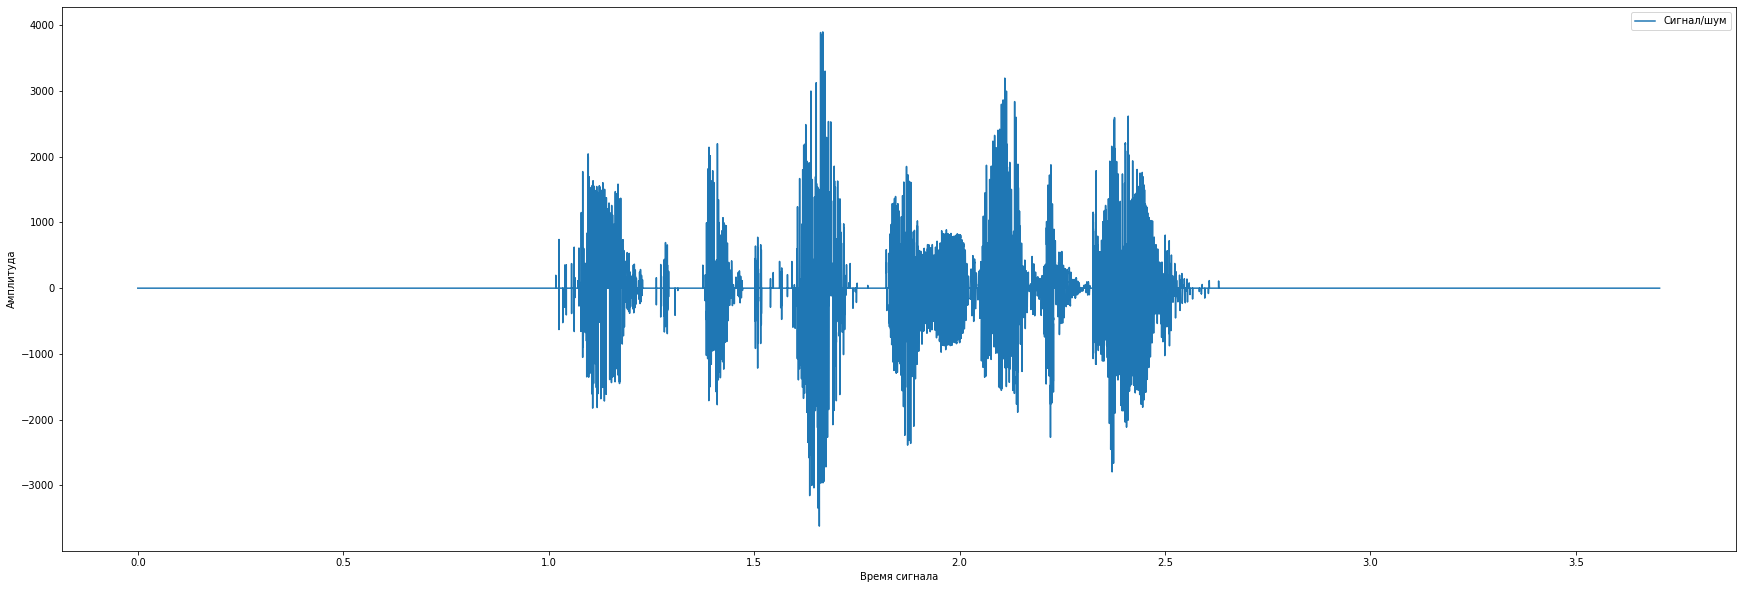

In [8]:
mid = 0
for k in range(data.shape[0]):
    mid += abs(data[k])
mid /= data.shape[0]

a = 0.2
th = a * mid

k = 20
j = 0
y = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    if abs(data[i]) > th:
        j += 1
        if (j >= 30):
            y[i] = data[i]
    else:
        j = 0
        
        
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.plot(stime, y, label="Сигнал/шум")
plt.legend()
plt.xlabel("Время сигнала")
plt.ylabel("Амплитуда")
plt.show()

y = y.astype(np.int16)
wavfile.write("detector.wav", samplerate, y)

## Звуковой эффект "Эхо"

- Ревербератор реализован, как набор линий задержки. Число линий задержки NL >= 8. Каждая линия задержки имеет свой весовой коэффициент (задается пользователем):
$α_1 > α_2 > · · · > α_{N_L}$
- Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.
- Желаемое соотношение между ”сухим” и обработанным сигналом задается коэффициентом применимости γ.
- Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка D1, а величины остальных определяются автоматически через нее: $D_i = D_1 2 \frac{1-i} {N_L}, i = 2, \dots,N_L$.

Для готовой конфигурации пользователь вручную задает последовательность
$D_1 > D_2 > · · · > D_{N_L}$.

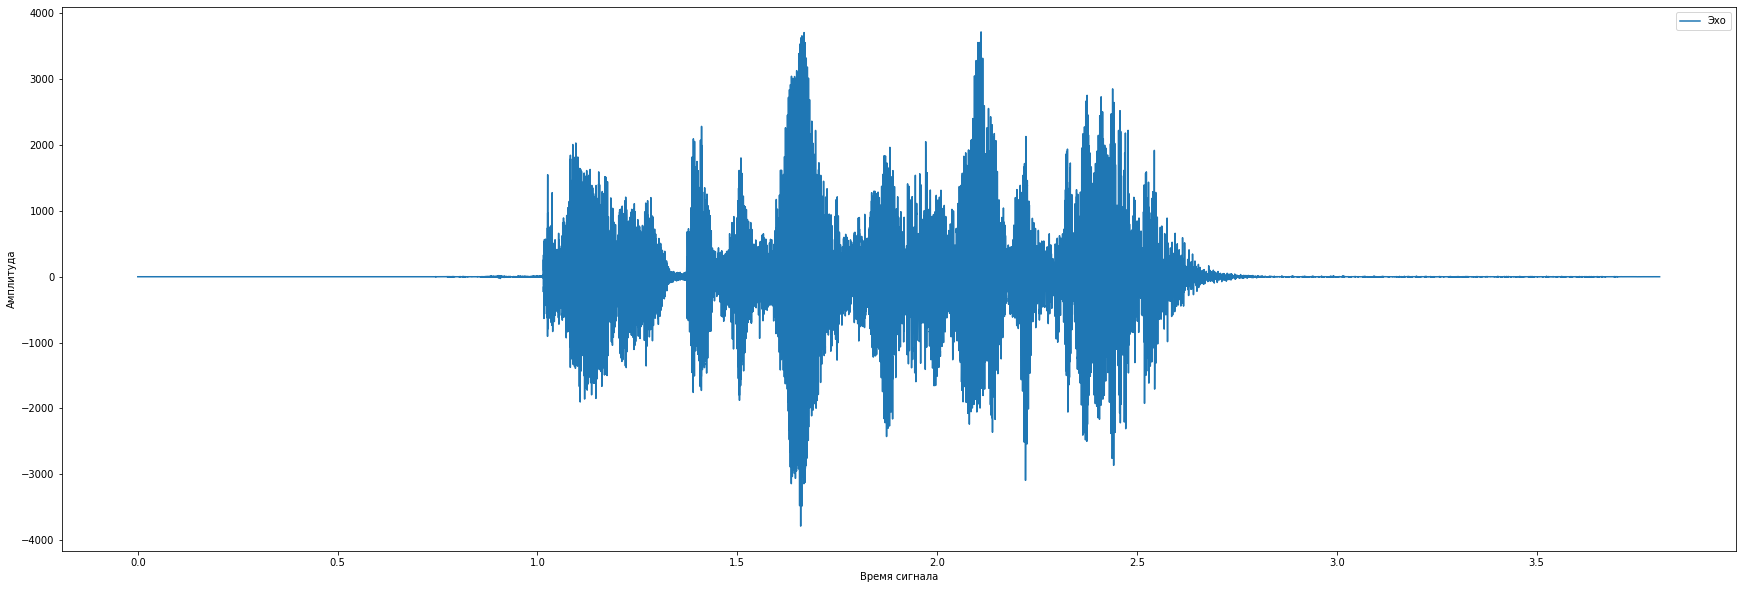

In [51]:
import random

nl = 8
gamma = 0.8
D = [5000]
a = []
for i in range(1, nl):
    D.append(round(D[0]*2**((-i)/nl)))#1-i было заменено на -i, чтобы элементы массива изменялись начиная с D[1], а не с D[2].
    
for i in range(8):
        a.append(round(random.random(), 2))
a.sort(reverse = True)#a рандомно гененируются

signals = []
for i in range(nl):
    sig = [0 for j in range(D[i])]
    sig.extend(data)
    signals.append([j*a[i] for j in sig])

echo = signals[0]
for i in range(1, nl):
    for j in range(len(signals[i])):
        echo[j] += signals[i][j]

fs = 600
wn = 2 * fs / samplerate

b, a = signal.butter(1, wn, 'lowpass')
filtered_echo = signal.filtfilt(b, a, echo)

for i in filtered_echo:
    i *= gamma
for i in range(len(data)):
    filtered_echo[i] += data[i]

elength = filtered_echo.shape[0] / samplerate
etime = np.linspace(0, elength, filtered_echo.shape[0])

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.plot(etime, filtered_echo, label="Эхо")
plt.legend()
plt.xlabel("Время сигнала")
plt.ylabel("Амплитуда")
plt.show()
    
filtered_echo = np.array(filtered_echo).astype(np.int16)
wavfile.write("echo.wav",samplerate, filtered_echo)

## Звуковой эффект "Distortion"

Обозначим входной сигнал и выходной сигналы, соответственно как x(i) и y(i), i = 0,1, . . . ,N − 1. Пользователь задает порог — Th и максимальное значение сигнала Max > Th. Тогда
$Y(i)=\begin{cases}
x(i), \quad \quad \quad \quad \quad \quad |x(i)|\leq Th,\\
Max*sign(x(i)), \quad |x(i)|> Th.
\end{cases}$

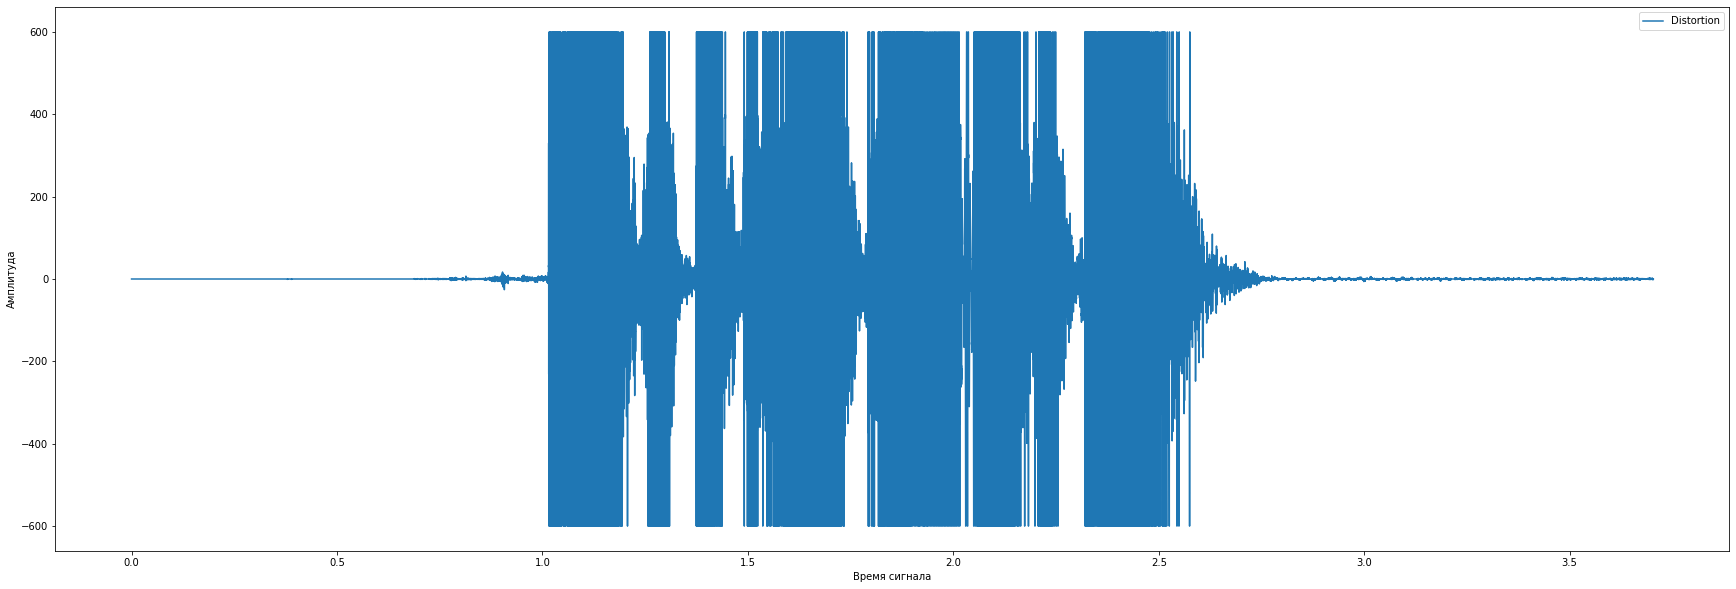

In [52]:
th = 400
Max = 600
y = []
for i in range(data.shape[0]):
    if abs(data[i]) > th:
        y.append(Max * np.sign(data[i]))
    else:
        y.append(data[i])

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.plot(stime, y, label="Distortion")
plt.legend()
plt.xlabel("Время сигнала")
plt.ylabel("Амплитуда")
plt.show()

y = np.array(y).astype(np.int16)
wavfile.write("distortion.wav",samplerate, y)